In [20]:
import sys
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf

from multiprocessing import Pool

import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import text, sequence
from keras.losses import binary_crossentropy
from keras.utils import to_categorical, Sequence
from keras.models import Model, Input, load_model
from keras.metrics import categorical_accuracy
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import f1_score, precision_recall_fscore_support
from keras.regularizers import l2
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from PIL import Image
from tqdm import tqdm
from imageio import imread
import imgaug as ia
from imgaug import augmenters as iaa
import cv2

from sklearn.model_selection import train_test_split, RepeatedKFold
from skimage.filters import sobel_h,sobel_v
from skimage.measure import block_reduce

# Modelling hyperparameters

In [21]:
BATCH_SIZE = 16
SEED = 777
SHAPE = (128, 128, 4)
DIR = os.getcwd()
VAL_RATIO = 0.1 # 10 % as validation
THRESHOLD = 0.5 # due to different cost of True Positive vs False Positive, this is the probability threshold to predict the class as 'yes'

ia.seed(SEED)

train_path = 'train/'
train_labels = pd.read_csv('./train.csv')
labels_path = './train.csv'
labels = train_labels

# Features augmentation 

## Edge detection using a sobel kernel

In [22]:
def grad(image):
    grad_x0=sobel_h(image[:,:,0])
    grad_y0=sobel_v(image[:,:,0])
    grad0=np.sqrt(grad_x0*grad_x0+grad_y0*grad_y0).T
    
    grad_x1=sobel_h(image[:,:,1])
    grad_y1=sobel_v(image[:,:,1])
    grad1=np.sqrt(grad_x1*grad_x1+grad_y1*grad_y1).T
    
    grad_x2=sobel_h(image[:,:,2])
    grad_y2=sobel_v(image[:,:,2])
    grad2=np.sqrt(grad_x2*grad_x2+grad_y2*grad_y2).T
    
    grad_x3=sobel_h(image[:,:,3])
    grad_y3=sobel_v(image[:,:,3])
    grad3=np.sqrt(grad_x3*grad_x3+grad_y3*grad_y3).T
    
    return np.array([grad0,grad1,grad2, grad3]).T

def grad_threshold(image, eps):
    
    return (grad(image) > eps)*255

## Compute gradient in multiple direction

In [23]:
def dirrectional_grad(image,theta):
    
    grad_x0 = np.cos(theta)*sobel_h(image[:,:,0]) + np.sin(theta)*sobel_v(image[:,:,0])
    grad_x1 = np.cos(theta)*sobel_h(image[:,:,1]) + np.sin(theta)*sobel_v(image[:,:,1])
    grad_x2 = np.cos(theta)*sobel_h(image[:,:,2]) + np.sin(theta)*sobel_v(image[:,:,2])
    grad_x3 = np.cos(theta)*sobel_h(image[:,:,3]) + np.sin(theta)*sobel_v(image[:,:,3])
    
    grad0= np.maximum(grad_x0,0).T
    grad1= np.maximum(grad_x1,0).T
    grad2= np.maximum(grad_x2,0).T
    grad3= np.maximum(grad_x3,0).T
    image= np.array([grad0,grad1,grad2, grad3]).T
    return image

# Data generator

In [24]:
def getTrainDataset():
    
    path_to_train = 'train/'
    data = pd.read_csv('./train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = 'test'
    data = pd.read_csv('sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)


In [25]:
# credits: https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
# credits: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, grad, dir_grad, grad_threshold, nb_threshold, nb_rot, reduce, block_size, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        self.grad = grad
        self.dir_grad = dir_grad
        self.grad_threshold = grad_threshold
        self.nb_threshold = nb_threshold 
        self.nb_rot = nb_rot
        self.reduce = reduce
        self.block_size = block_size
        self.shape_features = self.Shape(shape)
        self.shape = (self.batch_size, self.shape_features[0], self.shape_features[1], self.shape_features[2])
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    # using block to reduce the image size
    def Reduce(self, images):
        block=(self.block_size,self.block_size,1)
        return block_reduce(images,block,np.mean)
    
    # creating new channels with features augmentation
    def features_aumentation(self, image):    

        grad_= self.grad
        dir_grad_= self.dir_grad
        grad_threshold_= self.grad_threshold

        a=image

        if grad_:
            a=np.append(a,grad(image), axis=2)

        if dir_grad_:
            rot=np.arange(0, 360, 360//self.nb_rot)
            for i in rot:
                a=np.append(a,dirrectional_grad(image,i), axis=2)

        if grad_threshold_:
            eps=np.arange(0,128,128//self.nb_threshold)
            for e in eps:      
                a=np.append(a, grad_threshold(image,e), axis=2)

        return a
    
    # compute the shape of the input according to the features augmentation
    def Shape(self,shape):
        
        if self.reduce | self.block_size != 0: 
            h = shape[0]//self.block_size
            h_rest = (shape[0] % self.block_size)>0
        else:
            h, h_rest= shape[0], 0

        return (h+h_rest, h+h_rest, 4 + 4*self.grad + self.dir_grad*4*len(np.arange(0, 360, 360//self.nb_rot)) + self.grad_threshold*4*len(np.arange(0,128,128//self.nb_threshold)))
    
    #load the data according to the choice of the hyperparameters
    def get_loader(self,list_id):

        filenames = []
        idx = 0
        images = np.zeros(self.batch_shape)

        for image_id in list_id:
            
            if self.reduce:
                images[idx,:,:,:] = self.Reduce(self.features_aumentation(load_image(self.basepath, image_id)))
            else:
                images[idx,:,:,:] = self.features_aumentation(load_image(self.basepath, image_id))
            
            filenames.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                images = np.array(images)

                return filenames, get_label(filenames,self.labels), images
                
                filenames = []
                images = np.zeros(self.batch_shape)
                idx = 0
        
        if idx > 0:

            images = np.array(images)
            return filenames, get_label(filenames,self.labels), images
        
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros(self.shape)
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            
            if self.reduce:
                
                for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                    image = self.__load_image(path)
                    image = self.Reduce(self.features_aumentation(image))
                    self.is_cached[indexes[i]] = 1
                    self.cache[indexes[i]] = self.Reduce(self.features_aumentation(image))
                    X[i] = image
            else:
            
                for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                    image = self.__load_image(path)
                    image = self.features_aumentation(image)
                    self.is_cached[indexes[i]] = 1
                    self.cache[indexes[i]] = image
                    X[i] = image
        else:
            
            if self.reduce:
                
                for i, path in enumerate(paths):
                    image = self.__load_image(path)
                    image = self.Reduce(self.features_aumentation(image))
                    X[i] = image
            else:
                for i, path in enumerate(paths):
                    image = self.__load_image(path)
                    image = self.features_aumentation(image)
                    X[i] = image

        y = self.labels[indexes]
        
        #augment the data using different methods randomly
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Affine(rotate=0),
                    iaa.Affine(rotate=90),
                    iaa.Affine(rotate=180),
                    iaa.Affine(rotate=270),
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
                    iaa.ContrastNormalization((0.75, 1.5)),
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the
                    # pixels.
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
    
    # load images       
    def __load_image(self, path):
        R = Image.open(path + '_red.png')
        G = Image.open(path + '_green.png')
        B = Image.open(path + '_blue.png')
        Y = Image.open(path + '_yellow.png')

        im = np.stack((
            np.array(R), 
            np.array(G), 
            np.array(B),
            np.array(Y)), -1)
        
        im = cv2.resize(im, (SHAPE[0], SHAPE[1]))
        im = np.divide(im, 255)
        return im

In [26]:
# credits: https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras
# define metrics for the training

def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

In [27]:
# get the shape after cropping images

def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = (target.get_shape()[2] - refer.get_shape()[2]).value
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = (target.get_shape()[1] - refer.get_shape()[1]).value
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

# VGG

In [28]:
def create_VGG(input_shape, BATCH_NORM = True):

    input_layer = Input(input_shape)
    num_classes = 28

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(input_layer)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv4')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv4')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv4')(x)
    x = BatchNormalization()(x)if BATCH_NORM else None
    x = Activation('relu')(x)

    x = Flatten()(x)

    x = Dense(4096)(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)

    x = Dropout(0.5)(x)

    x = Dense(4096, name='fc2')(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(num_classes)(x)
    x = BatchNormalization()(x) if BATCH_NORM else None
    x = Activation('sigmoid')(x)

    model = Model(inputs=input_layer, outputs=x)

    return model

# Spoon model

In [29]:
# spoon-net

def create_model(input_shape):
    
    concat_axis = 3
    input = Input(input_shape)
        
    conv1 = Conv2D(32, (3, 3), padding="same", name="conv1_1", kernel_initializer='uniform',activation="relu", data_format="channels_last")(input)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)
    pool1= BatchNormalization()(pool1)

    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)
    pool2= BatchNormalization()(pool2)

    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv3)
    pool3= BatchNormalization()(pool3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv4)
    pool4= BatchNormalization()(pool4)

    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(conv5)

    up_conv5 = UpSampling2D(size=(2, 2),data_format="channels_last")(conv5)
    ch, cw = get_crop_shape(conv4, up_conv5)
    crop_conv4 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv4)
    up6   = concatenate([up_conv5, crop_conv4], axis=concat_axis)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(conv6)

    up_conv6 = UpSampling2D(size=(2, 2),data_format="channels_last")(conv6)
    ch, cw = get_crop_shape(conv3, up_conv6)
    crop_conv3 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv3)
    up7   = concatenate([up_conv6, crop_conv3], axis=concat_axis)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(conv7)

    up_conv7 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv7)
    ch, cw = get_crop_shape(conv2, up_conv7)
    crop_conv2 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv2)
    up8   = concatenate([up_conv7, crop_conv2], axis=concat_axis)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu", kernel_initializer='uniform',data_format="channels_last")(conv8)

    up_conv8 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv8)
    ch, cw = get_crop_shape(conv1, up_conv8)
    crop_conv1 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv1)
    up9   = concatenate([up_conv8, crop_conv1], axis=concat_axis)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu", kernel_initializer='uniform', data_format="channels_last")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu", kernel_initializer='uniform', data_format="channels_last")(conv9)

    x= conv9

    A = Conv2D(32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer='uniform',kernel_regularizer=l2(0.001))(x)
    A = MaxPooling2D(pool_size=2, strides=1, padding="valid")(A)
    A = BatchNormalization()(A)

    B = Conv2D(32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer='uniform',kernel_regularizer=l2(0.001))(A)
    B = MaxPooling2D(pool_size=2, strides=1, padding="valid")(B)
    B= BatchNormalization()(B)

    C = Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer='uniform',kernel_regularizer=l2(0.001))(B)
    C = MaxPooling2D(pool_size=2, strides=1, padding="valid")(C)
    C = BatchNormalization()(C)

    D = Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer='uniform',kernel_regularizer=l2(0.001))(C)
    D = MaxPooling2D(pool_size=2, strides=1, padding="valid")(D)
    D = BatchNormalization()(D)

    E = Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer='uniform',kernel_regularizer=l2(0.001))(D)
    E = MaxPooling2D(pool_size=2, strides=1, padding="valid")(E)
    E = BatchNormalization()(E)

    F = Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer='uniform',kernel_regularizer=l2(0.001))(E)
    F = MaxPooling2D(pool_size=2, strides=1, padding="valid")(F)
    F = BatchNormalization()(F)

    G = Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer='uniform',kernel_regularizer=l2(0.001))(F)
    G = MaxPooling2D(pool_size=2, strides=1, padding="valid")(G)
    G = BatchNormalization()(G)

    H = Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer='uniform',kernel_regularizer=l2(0.001))(G)
    H = MaxPooling2D(pool_size=2, strides=1, padding="valid")(H)
    H = BatchNormalization()(H)

    H= Flatten()(H)
    H= Dropout(0.3)(H)

    x = Dense((128),activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='uniform')(H)

    x=Dropout (0.3)(x)
    x=Dense((256),activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='uniform')(x)

    output = Dense(28, activation = "sigmoid", kernel_initializer='uniform')(x)

    model = Model(inputs=[input], outputs=[output])

    return model

# Data input

In [30]:
paths, labels = getTrainDataset()

In [31]:
# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

In [32]:
pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

In [33]:
print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

(31072,) (31072, 28)
(27964,) (27964, 28) (3108,) (3108, 28)


## Define train and validation set

In [34]:
tg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE,
                          grad = False, dir_grad = False, grad_threshold = False,
                          nb_rot= 4, nb_threshold=6, reduce=False, block_size=1,
                          use_cache=False, augment = False, shuffle = False)

In [35]:
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE,
                          grad = False, dir_grad = False, grad_threshold = False,
                          nb_rot= 4, nb_threshold=6, reduce=False, block_size=1,
                          use_cache=False, shuffle = False)

# Training

In [ ]:
# https://keras.io/callbacks/#modelcheckpoint
checkpoint = ModelCheckpoint('./spoon_augm.model', monitor='val_f1', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

In [ ]:
model = create_model(tg.shape_features)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc',f1])

model.summary()

In [ ]:
epochs = 100

use_multiprocessing = True # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
workers = 8 # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
'''init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
with tf.Session() as sess:
    sess.run(init_g)
    sess.run(init_l)'''

hist = model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1,
    callbacks=[checkpoint])

In [12]:
model.save('./best_one_spoon_aug_40_epochs.model')

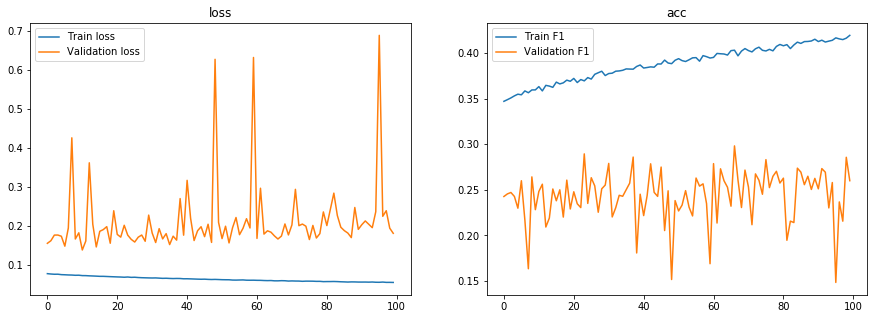

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

# Full validation
Perform validation on full validation dataset. Choose appropriate prediction threshold maximalizing the validation F1-score.

In [36]:
model = load_model('/Users/mohamed/Desktop/Deep Learning/best_one_spoon.model', custom_objects={'f1': f1}) #, 'f1_loss': f1_loss})

In [37]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 4)  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 128, 128, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv1_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

# On the cell below chosse vg for optimizing on the validation set and tg for optimizing on the training set

In [38]:
fullValGen = tg

In [39]:
lastFullValPred = np.empty((0, 28))
lastFullValLabels = np.empty((0, 28))
for i in tqdm(range(len(fullValGen))): 
    im, lbl = fullValGen[i]
    scores = model.predict(im)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
print(lastFullValPred.shape, lastFullValLabels.shape)

  0%|          | 1/1748 [00:52<25:35:57, 52.75s/it]

KeyboardInterrupt: 

In [14]:
from sklearn.metrics import f1_score as off1
rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0], 28))
for j,t in enumerate(tqdm(rng)):
    for i in range(28):
        p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
        scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
        f1s[j,i] = scoref1

 10%|▉         | 99/1000 [01:08<10:03,  1.49it/s]/home/ef2603jca2158/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 1000/1000 [11:08<00:00,  1.50it/s]


In [15]:
from sklearn.metrics import f1_score as off1
from sklearn.metrics import precision_recall_fscore_support
rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0], 28))
data = []
for j,t in enumerate(tqdm(rng)):
    score = precision_recall_fscore_support(lastFullValLabels, (lastFullValPred > t), average=None)
    data.append(pd.DataFrame(np.array([score[0], score[1], score[2]]).T, columns = ['Precision', 'Recall', 'F1']))

 10%|▉         | 99/1000 [00:20<02:58,  5.05it/s]/home/ef2603jca2158/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 1000/1000 [03:10<00:00,  5.54it/s]


In [16]:
index = []
for label in (np.arange(28)):
    best = 0
    for idx in range(len(data)):
        df = data[idx]
        if df['F1'][label]>best:
            best = df['F1'][label]
            idx2 = idx
    index.append(idx2)

Results = data[990]
# for label in (np.arange(28)):
#     finaldf.iloc[label]

for label in (np.arange(28)):
    Results.iloc[label] =data[index[label]].iloc[label]

In [17]:
Results

,Precision,Recall,F1
0,0.749213,0.820022,0.783020
1,0.733663,0.462790,0.567564
2,0.435485,0.819470,0.568733
3,0.129323,0.154594,0.140834
4,0.130767,0.510498,0.208202
5,0.259732,0.492529,0.340109
6,0.810189,0.532397,0.642555
7,0.772383,0.604520,0.678219
8,0.338028,0.136364,0.194332
9,0.600000,0.392857,0.474820


In [18]:
lb = []
rng = np.arange(0, 1, 0.001)
for idx in index:
    lb.append(rng[idx])

# Results optimized

In [19]:
np.mean(precision_recall_fscore_support(lastFullValLabels, (lastFullValPred > lb))[:3],axis=1)

array([0.50222926, 0.40315005, 0.42030969])

# Threshold

In [20]:
print('Probability threshold maximizing CV F1-score for each class:')
print(lb)

Probability threshold maximizing CV F1-score for each class:
[0.922, 0.324, 0.999, 0.073, 0.001, 0.016, 0.983, 0.99, 0.036000000000000004, 0.176, 0.09, 0.972, 0.046, 0.079, 0.679, 0.542, 0.252, 0.121, 0.051000000000000004, 0.058, 0.023, 0.097, 0.12, 0.666, 0.314, 0.023, 0.013000000000000001, 0.01]


# Create a submission

In [21]:
pathsTest, labelsTest = getTestDataset()

testg = ProteinDataGenerator(pathsTest, labelsTest, BATCH_SIZE, SHAPE)
submit = pd.read_csv('sample_submission.csv')
P = np.zeros((pathsTest.shape[0], 28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = model.predict(images)
    P[i*BATCH_SIZE:i*BATCH_SIZE+score.shape[0]] = score

100%|██████████| 183/183 [02:04<00:00,  1.37it/s]


In [22]:
PP = np.array(P)

In [23]:
prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    l_bis = np.array(lb)
    while str_label=='':
        for col in range(PP.shape[1]):
            if(PP[row, col] < l_bis[col]):
                str_label += ''
            else:
                str_label += str(col) + ' '
        l_bis=0.99*l_bis
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv('best_pred_submission_aug.csv', index=False)

100%|██████████| 11702/11702 [00:00<00:00, 41054.52it/s]


In [24]:
submit.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0 2
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 16
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


# Visualization fo the resuluts

In [25]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row
train_path = 'train/'
train_labels = pd.read_csv('./train.csv')
labels_path = './train.csv'
labels = train_labels
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)

In [26]:
proba_predictions_baseline = lastFullValPred

In [27]:
baseline_proba_predictions = pd.DataFrame(proba_predictions_baseline, columns=train_labels.drop(["Target", "number_of_targets", "Id"], axis=1).columns)
baseline_proba_predictions.head()

,Actin filaments,Aggresome,Cell junctions,Centrosome,Cytokinetic bridge,Cytoplasmic bodies,Cytosol,Endoplasmic reticulum,Endosomes,Focal adhesion sites,...,Mitotic spindle,Nuclear bodies,Nuclear membrane,Nuclear speckles,Nucleoli,Nucleoli fibrillar center,Nucleoplasm,Peroxisomes,Plasma membrane,Rods & rings
0,0.999700,0.001855,0.970606,0.047800,5.074902e-06,2.518818e-04,4.365859e-04,0.533183,6.151713e-04,3.350273e-06,...,1.114176e-04,3.250252e-03,3.099554e-03,4.476738e-06,3.293580e-04,0.000198,3.274348e-02,2.982811e-05,1.216210e-06,2.837635e-04
1,0.999986,0.000843,1.000000,0.000005,6.921140e-10,1.652448e-08,2.862340e-07,0.578030,6.491750e-09,2.443157e-16,...,5.359015e-10,3.801069e-07,4.650650e-10,1.166408e-11,3.474331e-10,0.000022,4.537802e-09,3.234564e-09,4.897824e-15,2.433987e-10
2,0.029993,0.026775,0.929866,0.004068,1.346929e-04,4.544507e-01,2.768854e-03,0.526594,2.579114e-06,3.940754e-07,...,1.539109e-02,4.972427e-03,7.612254e-06,2.447821e-06,3.500556e-05,0.000135,1.795568e-02,5.937852e-05,1.514463e-06,3.731925e-05
3,0.430861,0.498124,0.444328,0.330668,2.003128e-03,2.672720e-04,1.061614e-01,0.000002,5.254505e-08,1.820941e-12,...,3.258212e-06,1.957064e-06,2.062541e-07,7.144743e-08,4.216181e-09,0.982406,6.542097e-11,2.578419e-04,2.298854e-11,2.003536e-08
4,0.025492,0.000834,0.002105,0.000337,1.288790e-03,1.711351e-04,8.444892e-03,0.614128,1.791278e-06,8.381579e-04,...,9.107274e-01,7.671440e-04,8.000983e-06,4.121738e-03,6.903926e-03,0.000022,1.245766e-03,2.811244e-01,4.861603e-07,1.843189e-09


In [28]:
baseline_proba_predictions.to_csv("best_predictions_aug.csv")

In [29]:
baseline_proba_predictions = pd.read_csv("./best_predictions_aug.csv", index_col=0)
validation_labels = lastFullValLabels

In [30]:
proba_predictions = baseline_proba_predictions.values

In [31]:
hot_values = lastFullValLabels
one_hot = (hot_values.sum()) / hot_values.shape[0] * 100
zero_hot = (hot_values.shape[0] - hot_values.sum()) / hot_values.shape[0] * 100

/home/ef2603jca2158/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Percentage')

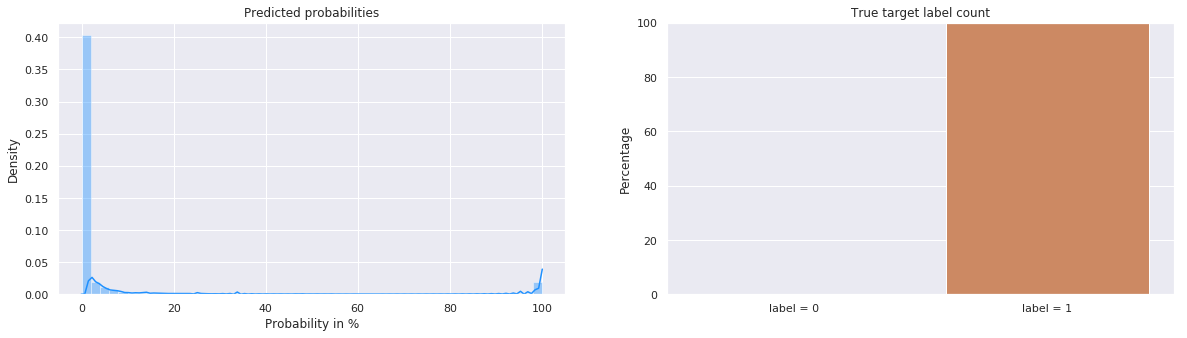

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(proba_predictions.flatten() * 100, color="DodgerBlue", ax=ax[0])
ax[0].set_xlabel("Probability in %")
ax[0].set_ylabel("Density")
ax[0].set_title("Predicted probabilities")
sns.barplot(x=["label = 0", "label = 1"], y=[zero_hot, one_hot], ax=ax[1])
ax[1].set_ylim([0,100])
ax[1].set_title("True target label count")
ax[1].set_ylabel("Percentage")

Text(0.5, 1.0, 'Standard deviation of predicted probability per class over all samples')

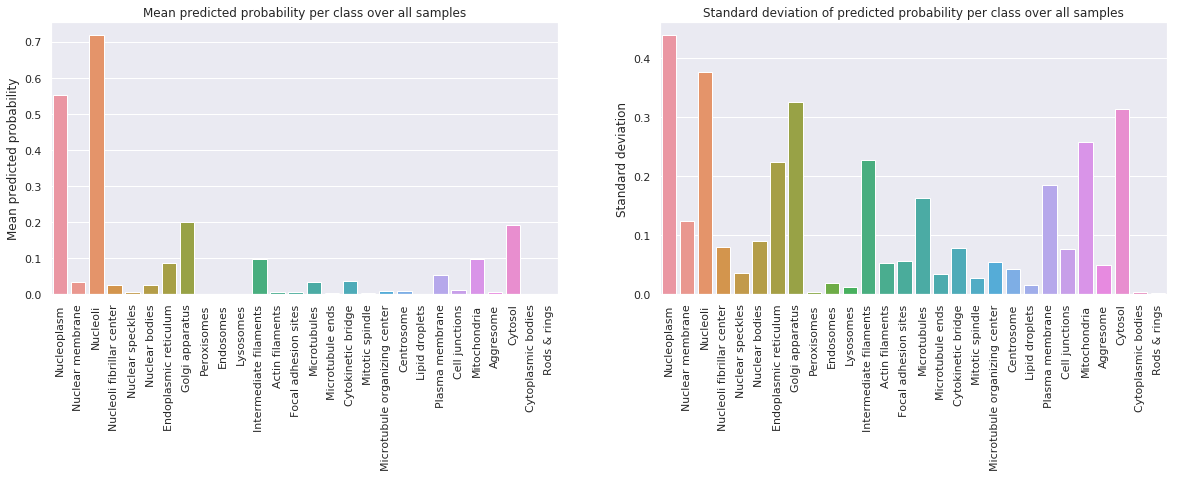

In [33]:
mean_predictions = np.mean(proba_predictions, axis=0)
std_predictions = np.std(proba_predictions, axis=0)
#mean_targets = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).fillna(0).mean()

#labels = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).columns.values
baselabels = baseline_proba_predictions.columns.values

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x=baselabels,
            y=mean_predictions,
            ax=ax[0])

ax[0].set_xticklabels(labels=label_names.values(),
                      rotation=90)
ax[0].set_ylabel("Mean predicted probability")
ax[0].set_title("Mean predicted probability per class over all samples")
sns.barplot(x=baselabels,
           y=std_predictions,
           ax=ax[1])

ax[1].set_xticklabels(labels=label_names.values(),
                      rotation=90)
ax[1].set_ylabel("Standard deviation")
ax[1].set_title("Standard deviation of predicted probability per class over all samples")

#plt.savefig("Unet.png")